## Table of Contents

1. [Enviroment setup](#env-setup)
2. [Load and process images](#data-loading)
3. [Algorithm implementation](#algorithm-implementation)

Todo for next session:
- Comentarii la cod, structura lui, main parts ca si headers cum e acum: 1., 2. dar mai in detaliu
- Implementat algoritmul din paper in cadrul unei operatii de convolutie custom 
- Facem si partea de img fusion sau ramanem la segmentare pe baza focus??
- Metoda obiectiva de avaluare a rezultatelor: cautat metrici pentru a masura asta

Nice to have:
- Scriem functiile in module, si in jupyter doar le importam si exemplificam ce fac
- Raport tehnic, + update la ppt

<a id="env-setup"></a>
# 1. Workspace Setup

## Downloading MFIF dataset

- To facilitate easy access to the required dataset for the image processing algorithm, we have provided a shell script that automates the download and setup process
- In order for data to be downloaded uncomment and run the cell below

In [3]:
# !./load_data.sh 

## Enviroment Setup

- Open a terminal in this working directory and create a conda enviroment using:  
```bash
conda env create -f environment.yml
```

- All packages required to run this project shall be installed using pip as follows:
```bash
pip install -r requirements.txt
```

<a id="data-loading"></a>
# 2. Load and process images

* Import the neccesary libraries to run this project
* Define a **path variable** that points towards the data directory that is created through the **.sh** script. 
* Create a class that handless the proces of retrieving paths to images from the data directory
* Use the paths to load and process images using <code>cv2</code>

In [4]:
from pathlib import Path
import os
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

In [5]:
class DataFolder:
    """
    This class is a wrapper for the folder containing images for the muti-focus fusion task.
    The folder contains a set of subfolders, each of which contains 2 images with opposite focus.
    """

    def __init__(self, path: Path):
        self.path = path

    def get_images(self, folder_name=None) -> np.ndarray[Path]:
        """
        Get the images from the specified folder_name. 
        If no name is provided the a random pair of images from the data folder are selected.
        """
        if folder_name is None:
            folder = self.path / np.random.choice(os.listdir(self.path))
        else:
            folder = self.path / folder_name
            
        img_paths = []
        for img in Path(folder.as_posix()).glob("*.jpg"):
            img_paths.append(img)

        return np.array(img_paths)

In [6]:
def process_images(img_paths: np.ndarray[Path]) -> np.ndarray:
    """
    Process a pair of images: convert to RGB.
    """
    imgs = []
    for img_path in img_paths:
        img = cv.imread(img_path.as_posix())
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgs.append(img)

    return np.array(imgs)

In [7]:
def plot_images(images: np.ndarray, titles: list[str] = ["Img1", "Img2"]):
    """
    Plot a pair of images.
    """
    # create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))
    for i, ax in enumerate(axes):
        if images[i].ndim == 2:
            ax.imshow(images[i], cmap="gray")
        else:
            ax.imshow(images[i])
        if titles:
            ax.set_title(titles[i])
        ax.axis("off")
        ax.set_yticks([])
    plt.show()

Data directory located at: 
	/home/astanea/code/image_processing/Image-Processing/data
Selecting images from the following paths:
	/home/astanea/code/image_processing/Image-Processing/data/mffw_07/mffw_07_A.jpg
	/home/astanea/code/image_processing/Image-Processing/data/mffw_07/mffw_07_B.jpg
Processed images with shape: (2, 520, 584, 3)
	Num images: 2
	Width: 520
	Height: 584
	Num channels: 3


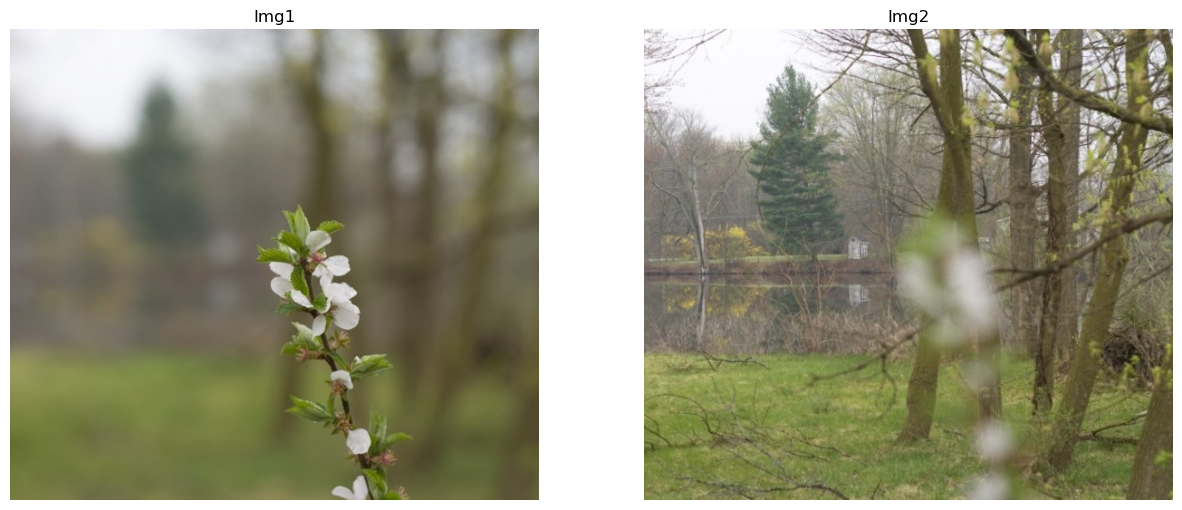

In [8]:
DATA_DIR = Path.cwd() / "data"
print(f"Data directory located at: \n\t{DATA_DIR.as_posix()}")

data_folder = DataFolder(DATA_DIR)

images = data_folder.get_images('mffw_07')
print("Selecting images from the following paths:")
for img in images:
    print(f"\t{img}")

images = process_images(images)
print(f"Processed images with shape: {images.shape}")
for descriptor, value in zip(
    ["Num images", "Width", "Height", "Num channels"], images.shape
):
    print(f"\t{descriptor}: {value}")

plot_images(images)

In [9]:
# RUN TO SEE AL IMAGES
# data_folder = DataFolder(DATA_DIR)

# for directory in sorted(os.listdir(DATA_DIR)):
#     images = data_folder.get_images(directory)
#     print(f'directory name is : {directory}')
#     plot_images(process_images(images))
    

<a id="algorithm-implementation"></a>

# 3. Algorithm implementation

## 3.1. SGML: Sum of the modified Laplacian

In [10]:
def plot_kernel_1D(kernel):
    plt.figure()
    plt.plot(kernel)
    plt.title("Representation of 1D Gaussian Kernel")
    plt.xlabel("Index")
    plt.ylabel("Kernel Value")
    plt.show()

In [11]:
def plot_kernel_2D(kernel):
    # Create the x and y coordinate arrays
    x = np.arange(kernel.shape[0])
    y = np.arange(kernel.shape[1])
    x, y = np.meshgrid(x, y)

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface
    ax.plot_surface(x, y, kernel, cmap="viridis")

    # Labels and title
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Kernel Value")
    ax.set_title("3D Representation of 2D Gaussian Kernel")

    # Show the plot
    plt.show()

In [12]:
kernel_size = 7
sigma = 2

gaussian_kernel_1D = cv.getGaussianKernel(kernel_size, sigma)
gaussian_kernel_2D = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())

print(f"gaussian_kernel_1D shape: {gaussian_kernel_1D.shape}")
print(f"gaussian_kernel_2D shape: {gaussian_kernel_2D.shape}")

gaussian_kernel_1D shape: (7, 1)
gaussian_kernel_2D shape: (7, 7)


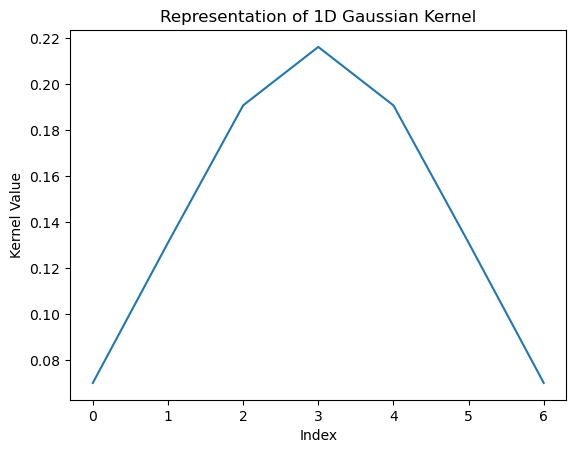

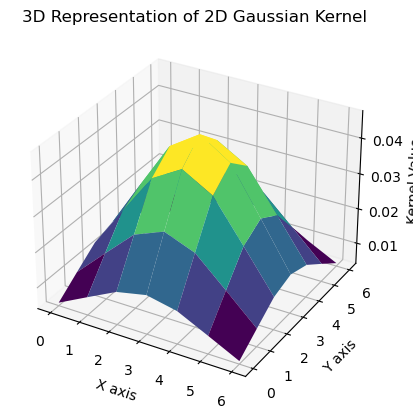

In [13]:
plot_kernel_1D(gaussian_kernel_1D)
plot_kernel_2D(gaussian_kernel_2D)

TODO: convolution iterator should shrink the image since the convolution removes some of the border

Utility methods:
* Define an iterator that gives acces to each step of the convolution operation: current (x,y) center as well as the surounding window. Used to add extra functionallyties such as convolving only elements that exceed a certain threshold.
* Images shring by an amount <TODO: ADD FORMULA HERE> during each convolution operation. In order to keep the same size after said operation we add padding to the image to compensate for the loos of pixels.

Side notes:
* Applying the proposed method over each individual color channel was not computationally efficient, for this reason we convert the image to grayscale before aplying the algorithm. Then the resulting trimap can be used to segment the image over the original color channels.

In [171]:
def convolution_iterator(img: np.ndarray, kernel, verbose=False):
    # img : 2D image -> W x H
    width_img, height_img = img.shape
    height_kernel, width_kernel = kernel

    if verbose:
        print(f"kernel_shape: {kernel.shape}")
        print(f"img shape: {img.shape}")

    # Loop through each pixel in the image skipping the outer edges of the image
    for y in range(height_kernel // 2, height_img - height_kernel // 2 ):
        for x in range(width_kernel // 2, width_img - width_kernel // 2 ):
            window = img[
                x - width_kernel // 2 : x + width_kernel // 2 + 1,
                y - height_kernel // 2 : y + height_kernel // 2 + 1,
            ]
            # TODO here should be - height_kernel // 2  for x, and y
            # SEE NEEDED CHANGES WHEN USING THE ITERATOR SINCE THE OUTPUT INMAGE SHOULD SHRING BY THE KERNEL SIZE
            yield (y - height_kernel//2, x - height_kernel//2, window)

In [172]:
def pad_images(images: np.ndarray, padding: int, border=cv.BORDER_CONSTANT):
    """Takes a list of images and pads them with zeros

    Args:
        images (np.ndarray): list containing images to be padded as numpy arrays
        padding (int): padding to be applied to each image. This is the number of pixels to be added to each individual side of the image.

    Returns:
        np.ndarray: padded images
    """
    padded_images = []

    for idx, img in enumerate(images):
        replicate = cv.copyMakeBorder(
            img, padding, padding, padding, padding, border, value=0
        )
        padded_images.append(replicate)

    return np.array(padded_images)

In [173]:
def ML(images, kernel_size, step_size=1):
    # TODO: check that the step size wont cause the window to go out of bounds
    center = kernel_size // 2
    
    print(f"center is {center}")
    
    ml_images = []
    for idx, img in enumerate(images):
        crnt_ml = np.zeros((img.shape[0] - kernel_size + 1, img.shape[1] - kernel_size + 1))
        
        print(f"crnt_ml.shape = {crnt_ml.shape}")
        
        for y, x, window in convolution_iterator(img, (kernel_size, kernel_size)):
            crnt_ml[y, x] = np.abs(
                2 * window[center, center] - window[center - step_size, center] - window[step_size + center, center]
            )
            +np.abs(2 * window[center, center] - window[center, center - step_size] - window[center, center + step_size])
        ml_images.append(crnt_ml)
    return np.array(ml_images)

In [174]:
def SGML(ml_images, crop_size, window_size):
    sigma=2
    threshold=0
    
    gaussian_kernel_1D = cv.getGaussianKernel(window_size, sigma)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())
    
    sgml_images = []
    for idx, img in enumerate(ml_images):
        crnt_img = np.zeros_like(img)
        for y, x, window in convolution_iterator(img, gaussian_kernel_2d.shape):
            crnt_step = (window * gaussian_kernel_2d)
                
            # ml_img_color_chn[y, x] = np.sum(np.array(crnt_step > threshold))
            # crnt_img[y, x] = np.sum(crnt_step)
            crnt_img[y, x] = np.sum(np.array(crnt_step > threshold))
            

        # add the cropped color channel to the current image
        sgml_images.append(crnt_img[crop_size:-crop_size, crop_size:-crop_size])
        
    return np.array(sgml_images)
    

In [175]:
img = images[0]
tmpimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

tmpimg.shape[0] - kernel_size + 1, tmpimg.shape[1] - kernel_size + 1, tmpimg.shape, kernel_size

(514, 578, (520, 584), 7)

In [176]:
max_x, max_y = -1, -1
Window= None
for y, x ,window in convolution_iterator(tmpimg, (kernel_size, kernel_size)):
    Window = window   
    
    if max_x == -1:
        print(f"window shape is {window.shape}")
        print(window[0])
    max_x = max(x, max_x) # ok
    max_y = max(y, max_y) # ok 

print(max_x, max_y)
print(Window.shape)

window shape is (7, 7)
[226 226 227 228 228 229 230]
513 577
(7, 7)


In [177]:
padding = (kernel_size - 1) // 2

print(f"Kernel size is: {kernel_size}")
print(f"Padding neede do keep same image dimensions: {padding}")

grayscale_imgages = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images])
print(f"Images shape before padding: {grayscale_imgages.shape}")

padded_images = pad_images(grayscale_imgages, padding, cv.BORDER_CONSTANT)
print(f"Images shape after padding: {padded_images.shape}")

ml_images = ML(padded_images, kernel_size)
print(f"Images shape after ML: {ml_images.shape}")

sgml_images= SGML(ml_images, padding, kernel_size)
print(f"Images shape after SGML: {sgml_images.shape}")

Kernel size is: 7
Padding neede do keep same image dimensions: 3
Images shape before padding: (2, 520, 584)
Images shape after padding: (2, 526, 590)
center is 3
crnt_ml.shape = (520, 584)


IndexError: index 520 is out of bounds for axis 0 with size 520

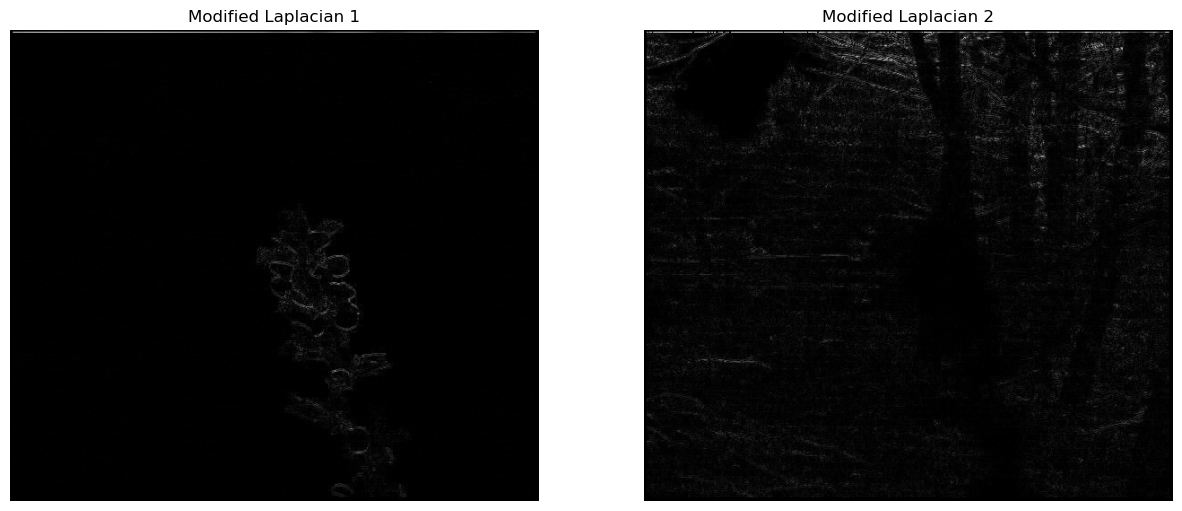

In [150]:
plot_images(ml_images, ["Modified Laplacian 1", "Modified Laplacian 2"])

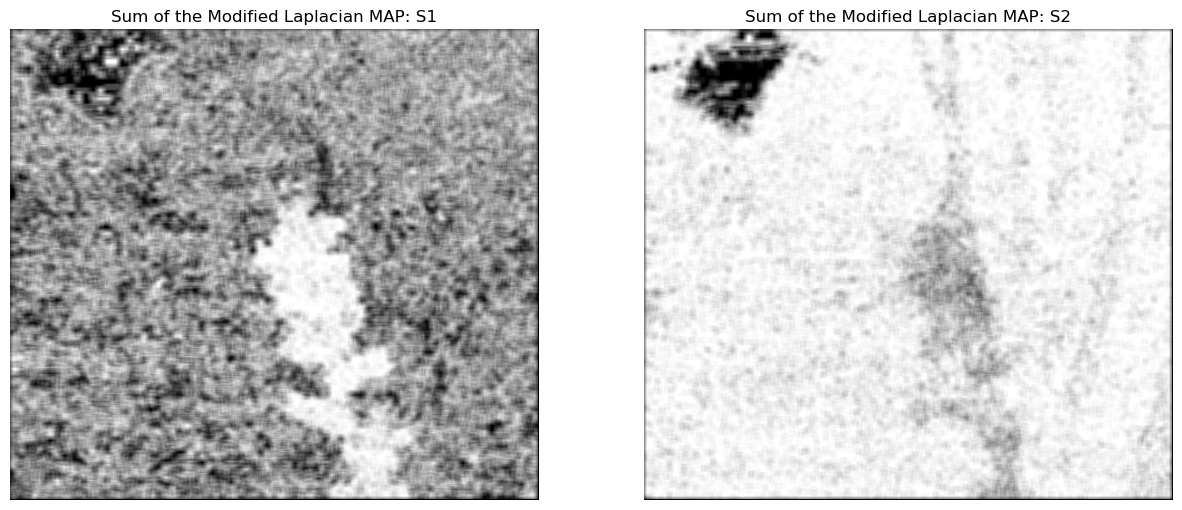

In [20]:
plot_images(sgml_images, ["Sum of the Modified Laplacian MAP: S1", "Sum of the Modified Laplacian MAP: S2"])

In [21]:
def compute_focus_score_maps(sgml_maps, patch_size=8, step_size=1):
    patch = np.ones((patch_size, patch_size))
    height_img, width_img = sgml_maps[0].shape

    S1, S2 = sgml_maps

    focus_socre_maps = np.zeros_like(sgml_maps)

    # Sliding window over the image
    for y in range(patch_size // 2, height_img - patch_size // 2 - 1, step_size):
        for x in range(patch_size // 2, width_img - patch_size // 2 - 1, step_size):
            window1 = S1[
                y - patch_size // 2 : y + patch_size // 2 + 1,
                x - patch_size // 2 : x + patch_size // 2 + 1,
            ]
            window2 = S2[
                y - patch_size // 2 : y + patch_size // 2 + 1,
                x - patch_size // 2 : x + patch_size // 2 + 1,
            ]

            k1 = np.sum(window1)
            k2 = np.sum(window2)

            if k1 > k2:
                focus_socre_maps[0][y, x] += 1
                # F1[y, x] += 1
            else:
                focus_socre_maps[1][y, x] += 1
                # F2[y, x] += 1

    F1, F2 = focus_socre_maps
    
    print(f"F1 shape: {F1.shape}")
    print(f"F2 shape: {F2.shape}")
    # return focus_socre_maps

    segmentation_maps = np.ones_like(focus_socre_maps) * 0.5
    print(f"segmentation_maps.shape {segmentation_maps.shape}")
    print(f"F1.shape[0] {F1.shape[0]}")
    print(f"F1.shape[1] {F1.shape[1]}")

    I1_IDX, I2_IDX = range(2)

    for y in range(F1.shape[0]):  # rows
        for x in range(F1.shape[1]):  # cols
            if F2[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 1
                segmentation_maps[I2_IDX, y, x] = 0
            elif F1[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 0
                segmentation_maps[I2_IDX, y, x] = 1
    
    # TODO: 
    # add step (4) : open and close operation
    # add step (5) : segmentation map
    
    

    return segmentation_maps

In [22]:
focus_score_maps = compute_focus_score_maps(sgml_images)

F1 shape: (520, 584)
F2 shape: (520, 584)
segmentation_maps.shape (2, 520, 584)
F1.shape[0] 520
F1.shape[1] 584


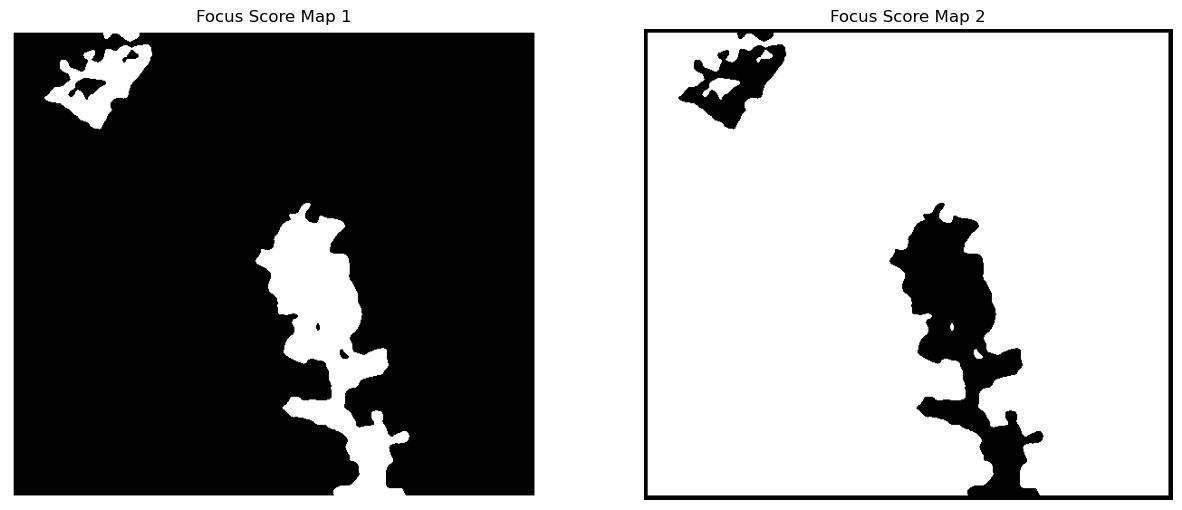

In [23]:
plot_images(focus_score_maps, ["Focus Score Map 1", "Focus Score Map 2"])

In [24]:
assert 1 == 2, "STOP HERE"

AssertionError: STOP HERE

In [ ]:
# #  Trying to implement the open and closing -> usually an erosion followed by a dilation
strucuting_elem = np.ones((5, 5))

eroison0 = cv.erode(focus_score_maps[0], strucuting_elem, iterations=1)
dilation0 = cv.dilate(eroison0, strucuting_elem, iterations=2)

eroison1 = cv.erode(focus_score_maps[1], strucuting_elem, iterations=1)
dilation1 = cv.dilate(eroison1, strucuting_elem, iterations=2)

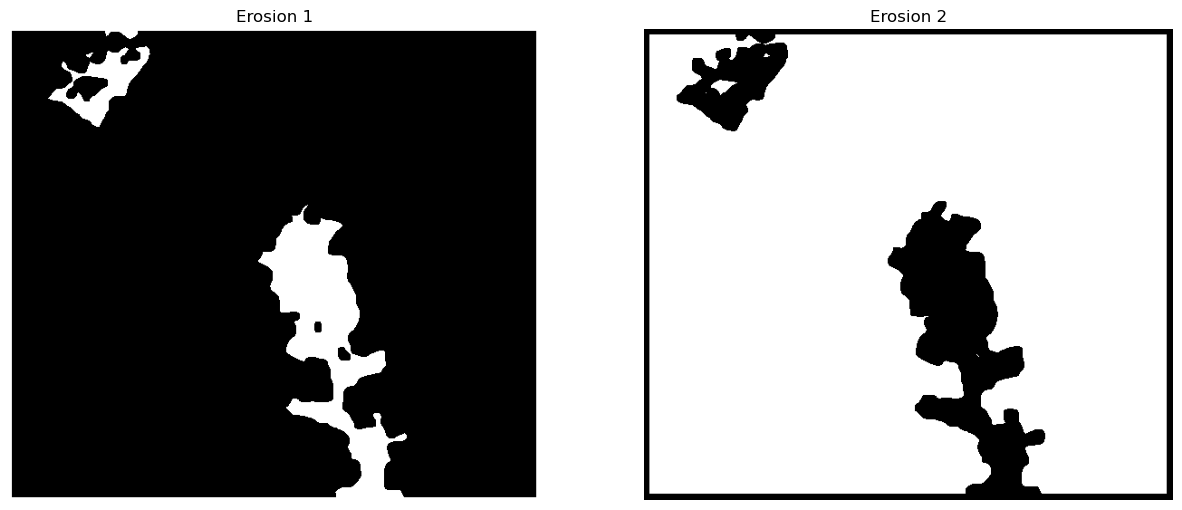

In [ ]:
plot_images([eroison0, eroison1], ["Erosion 1", "Erosion 2"])

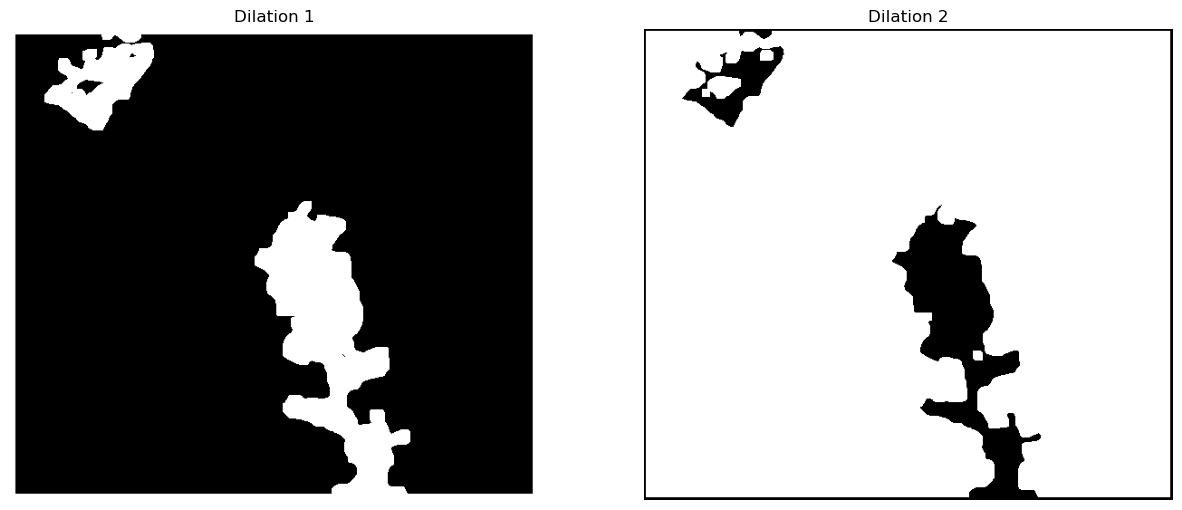

In [ ]:
plot_images([dilation0, dilation1], ["Dilation 1", "Dilation 2"])

## TESTING AREA

In [ ]:
grayscale_imgages = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images])

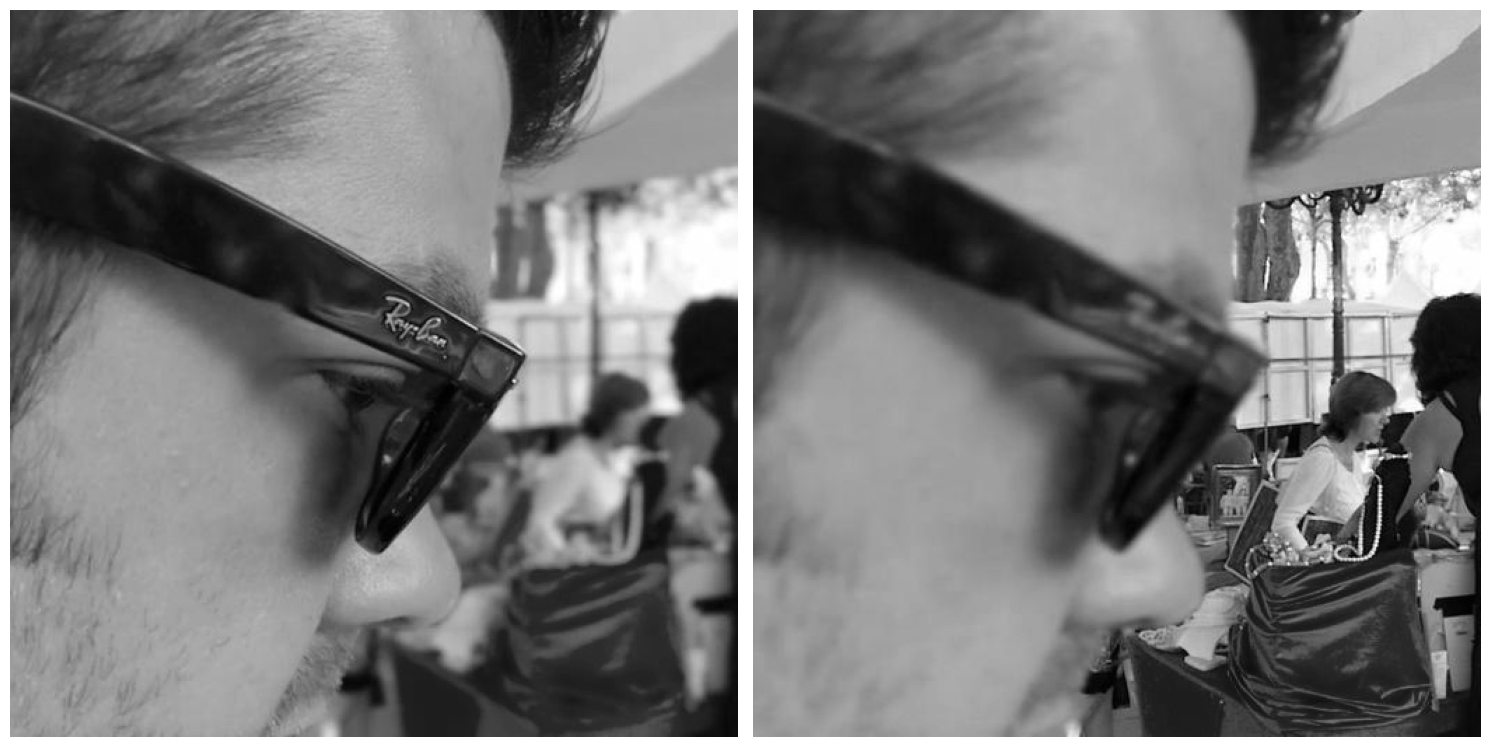

In [ ]:
plot_images(grayscale_imgages)

In [ ]:
grayscale_imgages.shape

(2, 520, 520)

# Algorithm implementation

## Sum of the Gaussian-based modified Laplacian

TODO: describe what a kernel is, gaussian distribution and the visualizations below
TODO: add .ini file with hyperparameters

In [ ]:
def convolution_iterator(img: np.ndarray, kernel, verbose=False):
    # img : 2D image -> W x H
    height_img, width_img = img.shape
    height_kernel, width_kernel = kernel
    
    if verbose:
        print(f"kernel_shape: {kernel.shape}")
        print(f"img shape: {img.shape}")

    # Loop through each pixel in the image skipping the outer edges of the image
    for y in range(height_kernel // 2, 
                   height_img - height_kernel // 2 - 1):
        for x in range(width_kernel // 2, 
                       width_img - width_kernel // 2 - 1):
            window = img[
                y - height_kernel // 2 : y + height_kernel // 2 + 1,
                x - width_kernel // 2 : x + width_kernel // 2 + 1,
            ]
            
            yield (y, x, window)


Compute the ML to extract edge information without loosing information when terms might cancel each other
- Based on reference [5] from our paper, the ML is computed over a window with size=3

In [ ]:
kernel_size = 7
padding = (kernel_size - 1) // 2

def pad_images(images: np.ndarray, padding: int, border=cv.BORDER_CONSTANT):
    """Takes a list of images and pads them with zeros

    Args:
        images (np.ndarray): list containing images to be padded as numpy arrays
        padding (int): padding to be applied to each image
    
    Returns:
        np.ndarray: padded images
    """
    padded_images = []
    
    for idx, img in enumerate(images):
        replicate = cv.copyMakeBorder(img,padding,padding,padding,padding, border,value=0)
        padded_images.append(replicate)
        
    return np.array(padded_images)

In [ ]:
padded_images = pad_images(images, padding, cv.BORDER_CONSTANT)

In [ ]:
images.shape, padded_images.shape

((2, 520, 520, 3), (2, 526, 526, 3))

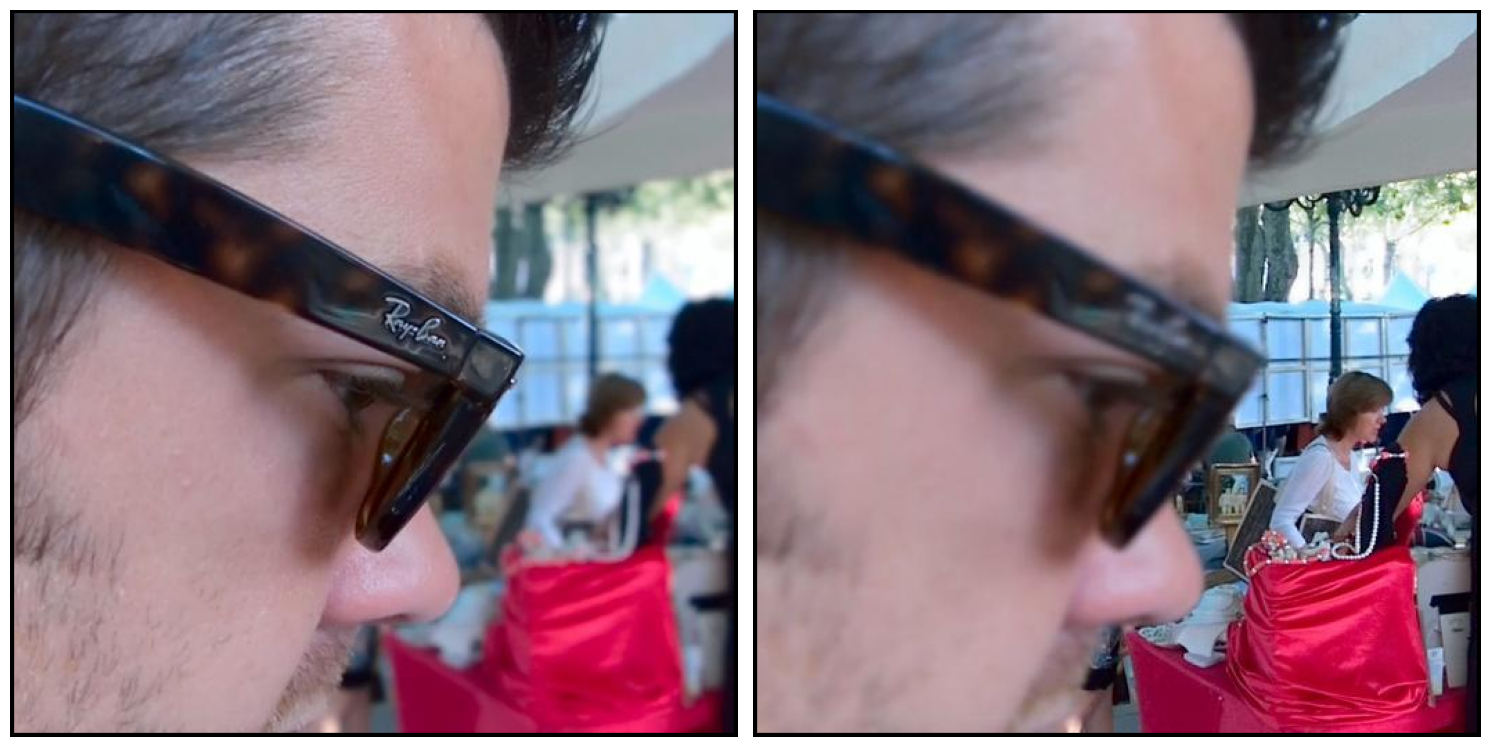

In [ ]:
plot_images(padded_images)

In [ ]:
def ML(images, step_size=1):
    # TODO: check that the step size wont cause the window to go out of bounds
    grayscale_imgages = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images])
    
    
    ml_images = []
    for idx, img in enumerate(grayscale_imgages):
        crnt_ml = np.zeros_like(img)
        for y, x, window in convolution_iterator(img, (7,7)):
            crnt_ml[y, x] = np.abs(2*img[y,x] - img[y-step_size,x] - img[y+step_size,x]) + \
                                        np.abs(2*img[y,x] - img[y,x-step_size] - img[y,x+step_size])
        ml_images.append(crnt_ml)
    return np.array(ml_images)

In [ ]:
ml_images = ML(padded_images)
ml_images.shape

(2, 526, 526)

In [ ]:
padded_images.shape,  images.shape, ml_images.shape

((2, 526, 526, 3), (2, 520, 520, 3), (2, 526, 526))

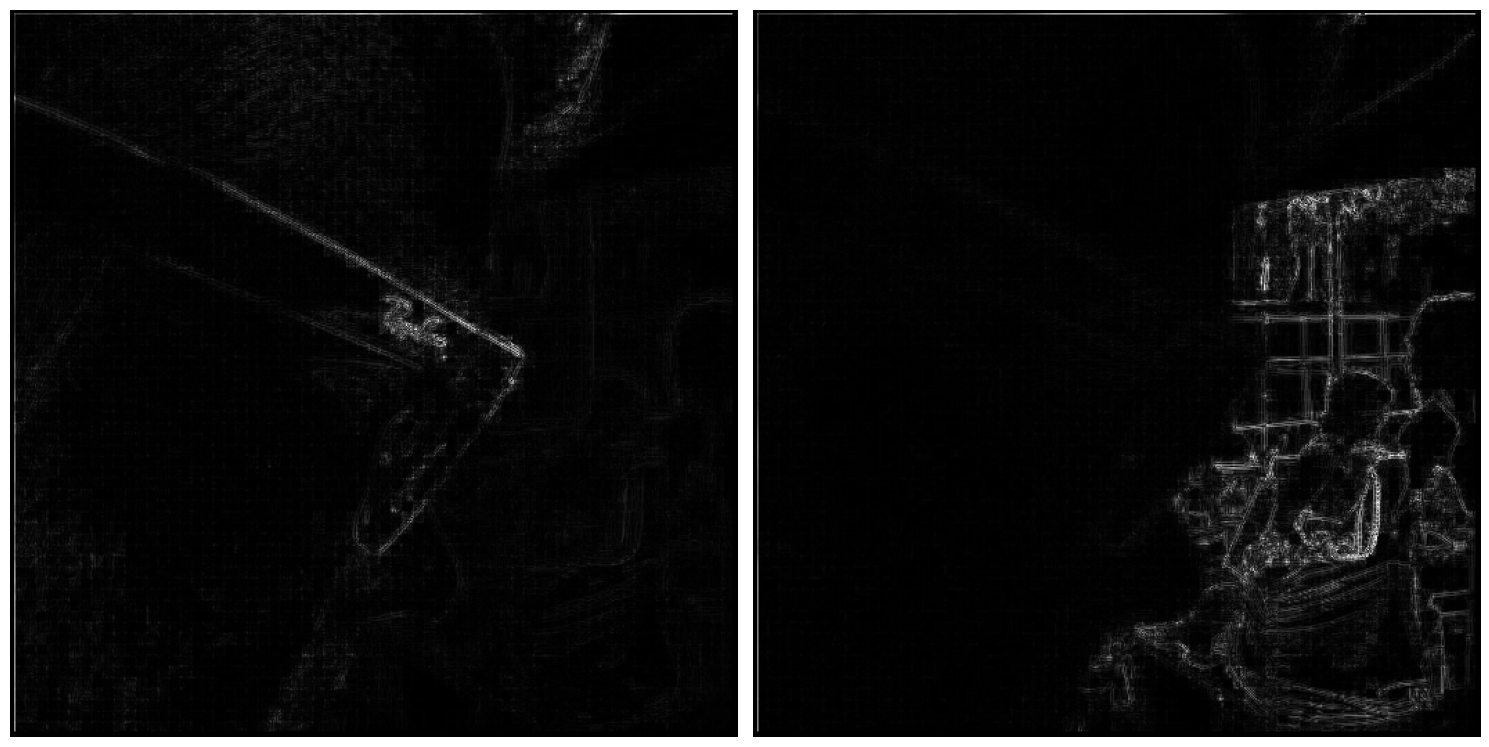

In [ ]:
# View result of the ML
COLOR_CHN = 1
plot_images(ml_images)
# plot_images(ml_images[:, :, :, COLOR_CHN])

In [ ]:
def SGML(ml_images, window_size=7, crop_size=padding):
    sigma=2
    threshold=0
    
    gaussian_kernel_1D = cv.getGaussianKernel(window_size, sigma)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())
    
    sgml_images = []
    for idx, img in enumerate(ml_images):
        crnt_img = np.zeros_like(img)
        for y, x, window in convolution_iterator(img, gaussian_kernel_2d.shape):
            crnt_step = (window * gaussian_kernel_2d)
                
            # ml_img_color_chn[y, x] = np.sum(np.array(crnt_step > threshold))
            crnt_img[y, x] = np.sum(crnt_step)

        # add the cropped color channel to the current image
        sgml_images.append(crnt_img[crop_size:-crop_size, crop_size:-crop_size])
        
    return np.array(sgml_images)
    

In [ ]:
sgml_maps = SGML(ml_images)

In [ ]:
sgml_maps.shape, images.shape, sgml_maps.min(), sgml_maps.max()

((2, 520, 520), (2, 520, 520, 3), 0, 138)

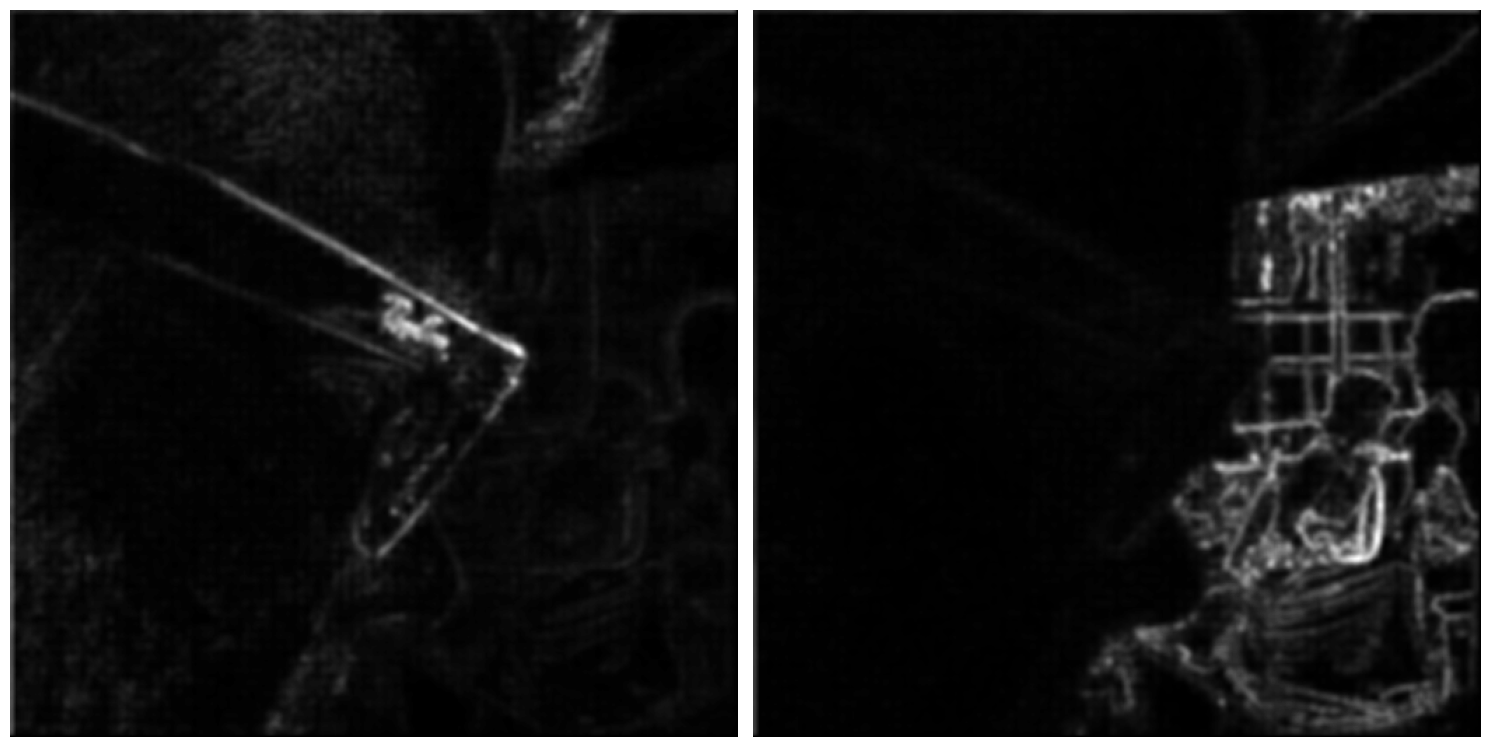

In [ ]:
# View result of the ML
COLOR_CHN = 1
plot_images(sgml_maps)

In [ ]:
assert 1 == 2, "Error: this is a test"

AssertionError: Error: this is a test

## Strategy of initial segmentation

In [ ]:
def compute_focus_score_maps(sgml_maps, patch_size=8, step_size=1):
    patch = np.ones((patch_size,patch_size))
    height_img, width_img = sgml_maps[0].shape
    
    S1, S2 = sgml_maps
    
    focus_socre_maps = np.zeros_like(sgml_maps)
    F1, F2 = focus_socre_maps
    
    # Sliding window over the image
    for y in range(patch_size // 2, 
                   height_img - patch_size // 2 - 1,
                   step_size):
        for x in range(patch_size // 2, 
                       width_img - patch_size // 2 - 1,
                       step_size):
            window1 = S1[
                y - patch_size // 2 : y + patch_size // 2 + 1,
                x - patch_size // 2 : x + patch_size // 2 + 1,
            ]
            window2 = S2[
                y - patch_size // 2 : y + patch_size // 2 + 1,
                x - patch_size // 2 : x + patch_size // 2 + 1,
            ]
            
            k1 = np.sum(window1)
            k2 = np.sum(window2)
            
            if k1 > k2:
                F1[y, x] += 1
            else:
                F2[y, x] += 1
                
    print(f"F1 shape: {F1.shape}")
    print(f"F2 shape: {F2.shape}")
    
    segmentation_maps = np.ones_like(focus_socre_maps) * 0.5
    print(f"segmentation_maps.shape {segmentation_maps.shape}")
    print(f"F1.shape[0] {F1.shape[0]}")
    print(f"F1.shape[1] {F1.shape[1]}")
    
    I1_IDX, I2_IDX = range(2)
    
    
    for y in range(F1.shape[0]): # rows
        for x in range(F1.shape[1]): # cols
            if F2[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 1
                segmentation_maps[I2_IDX, y, x] = 0
            elif F1[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 0
                segmentation_maps[I2_IDX, y, x] = 1
                
    return segmentation_maps    

In [ ]:
segmentation_maps = compute_focus_score_maps(sgml_maps)

F1 shape: (520, 520)
F2 shape: (520, 520)
segmentation_maps.shape (2, 520, 520)
F1.shape[0] 520
F1.shape[1] 520


In [ ]:
segmentation_maps.shape

(2, 520, 520)

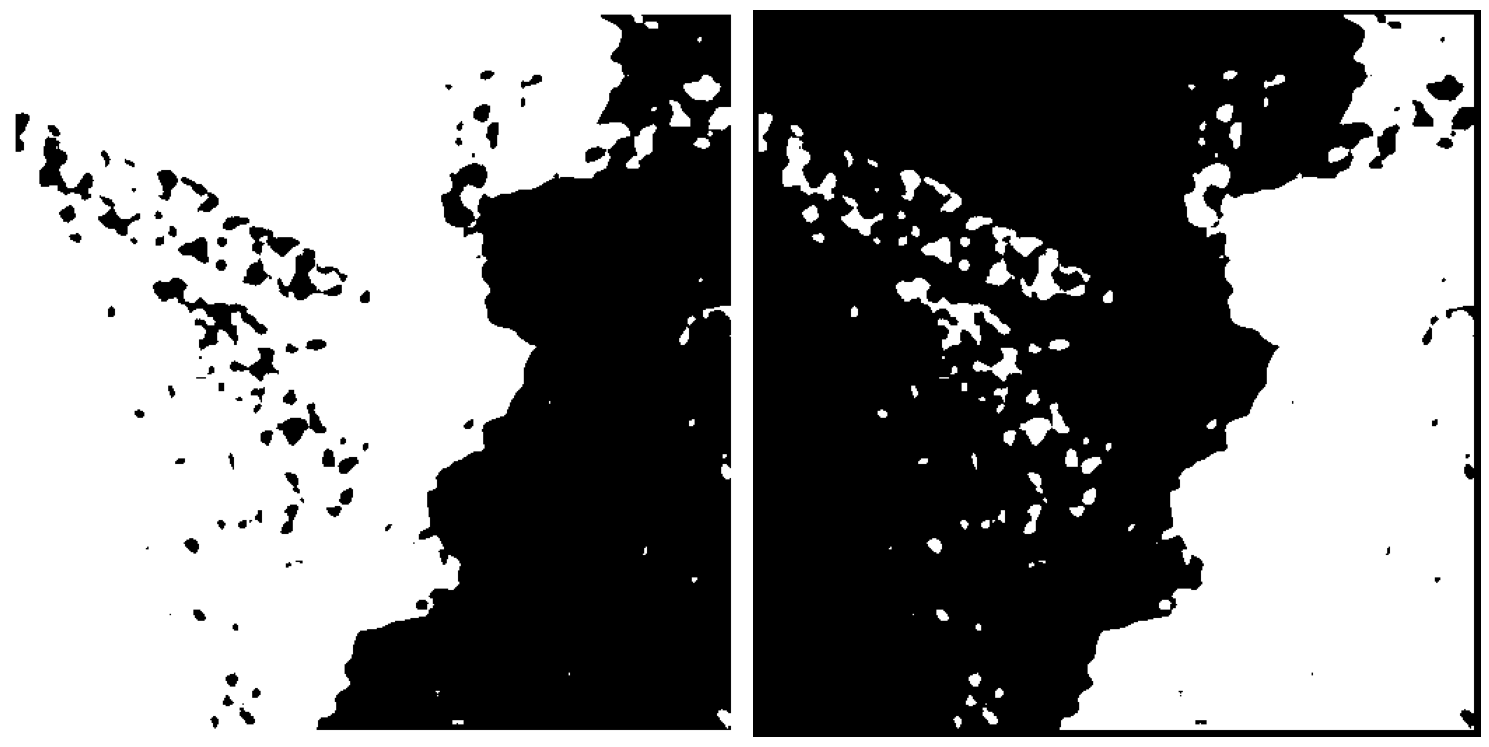

In [ ]:
plot_images(segmentation_maps)

In [ ]:
def open_close_operation(segmentation_maps):
    T=np.ones_like(segmentation_maps.shape[1:])
    

In [ ]:
crnt_img = red_angle
for k in range(1,8):
    # compute crnt treshold
    placeHolder = np.zeros_like(crnt_img.shape)
    
    # ar fi nested fors
    # mergi pe linii si coloane si pui in placeholder si compari crn img cu threshold -> rez in placeholder
    
    # crnt_img = placeHolder    
    
    
    

In [ ]:
assert 1 == 2, "Error: this is a test"

AssertionError: Error: this is a test

## Image mating technique for fusion

In [ ]:
assert 1 == 2, "Error: this is a test"

In [ ]:
a=list(range(10))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# OFFICIAL CV2 IMPLEMENTATION
kernel_size = 7
sigma = 2 
gaussian_kernel_1D = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_kernel_2d = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())

print(f"gaussian_kernel_1D shape: {gaussian_kernel_1D.shape}")
print(f"gaussian_kernel_2d shape: {gaussian_kernel_2d.shape}")

NameError: name 'cv2' is not defined

In [ ]:
def plot_kernel_1D(kernel):
    plt.figure()
    plt.plot(kernel)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Representation of 1D Kernel')
    plt.show()
    
def plot_kernel_2D(kernel):
    # Create the x and y coordinate arrays
    x = np.arange(kernel.shape[0])
    y = np.arange(kernel.shape[1])
    x, y = np.meshgrid(x, y)

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x, y, kernel, cmap='viridis')

    # Labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Kernel Value')
    ax.set_title('3D Representation of 2D Kernel')

    # Show the plot
    plt.show()    

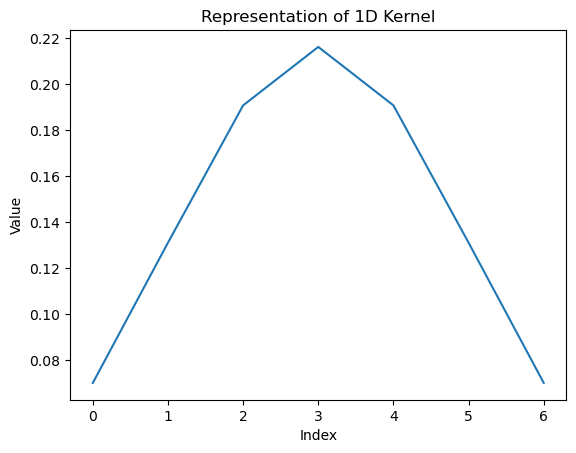

In [ ]:
plot_kernel_1D(gaussian_kernel_1D)

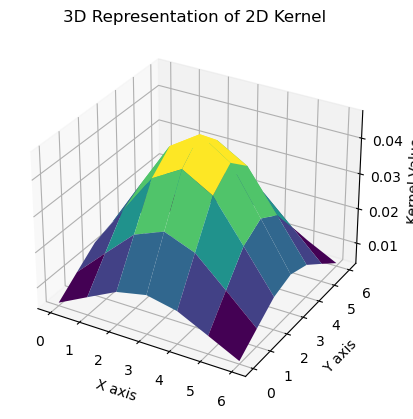

In [ ]:
plot_kernel_2D(gaussian_kernel_2d)

In [ ]:
def ML(img, s=1):
    
    pass

In [ ]:
def SGML(img=None, sigma=2, kernel_size=7):
    """Applies the Sum of the Gaussian-based modified Laplacian (SGML) filter to the input image

    Args:
        img (np.ndarray): image to be filtered
        sigma (int, optional): standard deviation of the Gaussian Kernel. Defaults to 2.
        r (int, optional): kernel size. Defaults to 7.

    Returns:
        np.ndarray: filtered image
    """
    assert kernel_size%2 == 1 and kernel_size > 1, "kernel_size must be an odd number greater than 1"
    assert sigma > 0, "sigma must be greater than 0"
    

# Paper implementation of algorithm: image focus score

## References:
- https://github.com/OmarMSaad/1D-Modified-Laplacian-of-Gaussian-Filter-for-Smoothing-and-Denoising-/tree/master